In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Parameters
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32
EPOCHS_FROZEN = 10
EPOCHS_UNFROZEN = 30

In [4]:
# --- 1. Data Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Simulates RandomBrightnessContrast
    zoom_range=0.1,               # Simulates ShiftScale
    rotation_range=10,            # Rotation
    width_shift_range=0.05,       # Simulates ShiftScale
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# --- 2. Data Generators ---
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/output_dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/output_dataset/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1920 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


In [ ]:
# --- 3. Model Setup ---
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_model_frozen.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# --- 5. Phase 2: Unfreeze Last Layers ---
# Unfreeze last 30 layers of DenseNet121
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_unfrozen = ModelCheckpoint(
    'best_model_unfrozen.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train Unfrozen Layers
model.fit(
    train_generator,
    epochs=EPOCHS_UNFROZEN,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint_unfrozen]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3592 - loss: 1.1108 
Epoch 1: val_loss improved from inf to 1.03378, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 967s 15s/step - accuracy: 0.3597 - loss: 1.1102 - val_accuracy: 0.4167 - val_loss: 1.0338
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5951 - loss: 0.9189
Epoch 2: val_loss improved from 1.03378 to 0.88881, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.5957 - loss: 0.9185 - val_accuracy: 0.6625 - val_loss: 0.8888
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7411 - loss: 0.7895
Epoch 3: val_loss improved from 0.88881 to 0.76059, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.7411 - loss: 0.7892 - val_accuracy: 0.7833 - val_loss: 0.7606
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7595 - loss: 0.7085
Epoch 4: val_loss improved from 0.76059 to 0.66127, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.7599 - loss: 0.7081 - val_accuracy: 0.8125 - val_loss: 0.6613
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7933 - loss: 0.6516
Epoch 5: val_loss improved from 0.66127 to 0.58469, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.7934 - loss: 0.6513 - val_accuracy: 0.8375 - val_loss: 0.5847
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8242 - loss: 0.5912
Epoch 6: val_loss improved from 0.58469 to 0.52851, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8241 - loss: 0.5912 - val_accuracy: 0.8583 - val_loss: 0.5285
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8352 - loss: 0.5585
Epoch 7: val_loss improved from 0.52851 to 0.48431, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8352 - loss: 0.5582 - val_accuracy: 0.8750 - val_loss: 0.4843
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8505 - loss: 0.5103
Epoch 8: val_loss improved from 0.48431 to 0.44897, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8506 - loss: 0.5103 - val_accuracy: 0.8833 - val_loss: 0.4490
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8602 - loss: 0.4935
Epoch 9: val_loss improved from 0.44897 to 0.42128, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8603 - loss: 0.4931 - val_accuracy: 0.8875 - val_loss: 0.4213
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8632 - loss: 0.4503
Epoch 10: val_loss improved from 0.42128 to 0.39706, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8632 - loss: 0.4503 - val_accuracy: 0.8917 - val_loss: 0.3971
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8793 - loss: 0.4217
Epoch 11: val_loss improved from 0.39706 to 0.37592, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8793 - loss: 0.4216 - val_accuracy: 0.8958 - val_loss: 0.3759
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8872 - loss: 0.3813
Epoch 12: val_loss improved from 0.37592 to 0.35776, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8871 - loss: 0.3814 - val_accuracy: 0.9000 - val_loss: 0.3578
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8795 - loss: 0.3974
Epoch 13: val_loss improved from 0.35776 to 0.34021, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.8798 - loss: 0.3971 - val_accuracy: 0.9000 - val_loss: 0.3402
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9105 - loss: 0.3486
Epoch 14: val_loss improved from 0.34021 to 0.32513, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9104 - loss: 0.3487 - val_accuracy: 0.9083 - val_loss: 0.3251
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9095 - loss: 0.3288
Epoch 15: val_loss improved from 0.32513 to 0.30895, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9094 - loss: 0.3290 - val_accuracy: 0.9083 - val_loss: 0.3089
Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9031 - loss: 0.3280
Epoch 16: val_loss improved from 0.30895 to 0.29627, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9031 - loss: 0.3281 - val_accuracy: 0.9125 - val_loss: 0.2963
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9085 - loss: 0.3166
Epoch 17: val_loss improved from 0.29627 to 0.28776, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9085 - loss: 0.3166 - val_accuracy: 0.9167 - val_loss: 0.2878
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9122 - loss: 0.3157
Epoch 18: val_loss improved from 0.28776 to 0.27969, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9122 - loss: 0.3156 - val_accuracy: 0.9167 - val_loss: 0.2797
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9146 - loss: 0.3072
Epoch 19: val_loss improved from 0.27969 to 0.26948, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9146 - loss: 0.3071 - val_accuracy: 0.9208 - val_loss: 0.2695
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9214 - loss: 0.2686
Epoch 20: val_loss improved from 0.26948 to 0.26266, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9214 - loss: 0.2687 - val_accuracy: 0.9250 - val_loss: 0.2627
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9132 - loss: 0.2923
Epoch 21: val_loss improved from 0.26266 to 0.25223, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9132 - loss: 0.2921 - val_accuracy: 0.9250 - val_loss: 0.2522
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9219 - loss: 0.2680
Epoch 22: val_loss improved from 0.25223 to 0.24536, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9220 - loss: 0.2679 - val_accuracy: 0.9250 - val_loss: 0.2454
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9266 - loss: 0.2666
Epoch 23: val_loss improved from 0.24536 to 0.23812, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9266 - loss: 0.2665 - val_accuracy: 0.9250 - val_loss: 0.2381
Epoch 24/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9383 - loss: 0.2497
Epoch 24: val_loss improved from 0.23812 to 0.23362, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9383 - loss: 0.2496 - val_accuracy: 0.9375 - val_loss: 0.2336
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9274 - loss: 0.2449
Epoch 25: val_loss improved from 0.23362 to 0.22907, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9275 - loss: 0.2448 - val_accuracy: 0.9375 - val_loss: 0.2291
Epoch 26/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9333 - loss: 0.2366
Epoch 26: val_loss improved from 0.22907 to 0.22417, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.9333 - loss: 0.2366 - val_accuracy: 0.9375 - val_loss: 0.2242
Epoch 27/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9325 - loss: 0.2268
Epoch 27: val_loss improved from 0.22417 to 0.21697, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9326 - loss: 0.2267 - val_accuracy: 0.9417 - val_loss: 0.2170
Epoch 28/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9381 - loss: 0.2279
Epoch 28: val_loss improved from 0.21697 to 0.21602, saving model to best_model_unfrozen.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9381 - loss: 0.2280 - val_accuracy: 0.9458 - val_loss: 0.2160
Epoch 29/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9445 - loss: 0.2053
Epoch 29: val_loss did not improve from 0.21602
60/60 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9444 - loss: 0.2054 - val_accuracy: 0.9458 - val_loss: 0.2180
Epoch 30/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9411 - loss: 0.2168
Epoch 30: val_loss did not improve from 0.21602
60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9411 - loss: 0.2167 - val_accuracy: 0.9417 - val_loss: 0.2161


Found 240 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 242s 30s/step
Test Accuracy: 0.9458 (94.58%)

Classification Report:
              precision    recall  f1-score   support

      health       0.99      0.96      0.97        80
        sick       0.99      0.90      0.94        80
          tb       0.88      0.97      0.92        80

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240


Confusion Matrix:
[[77  0  3]
 [ 0 72  8]
 [ 1  1 78]]


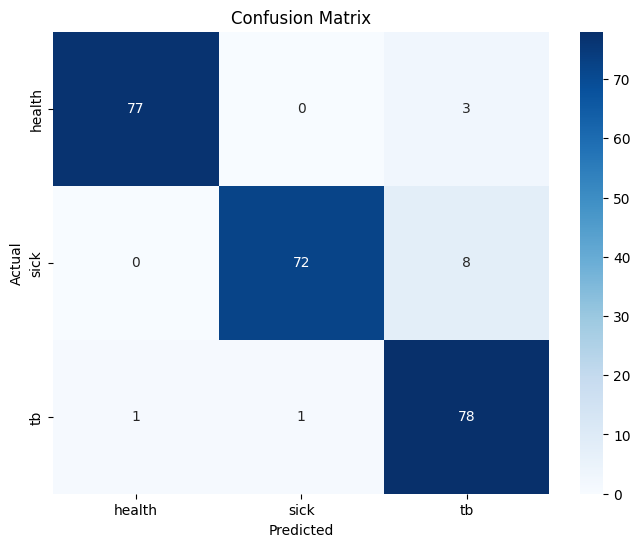


Class-wise Accuracy:
health: 0.9625 (96.25%)
sick: 0.9000 (90.00%)
tb: 0.9750 (97.50%)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('/content/drive/MyDrive/best_model_unfrozen.h5')  # Replace with your .h5 file path

# Set up test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data (adjust path to your test folder)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/output_dataset/val',  # Replace with your test folder path
    target_size=(512, 512),  # Your image size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print class-wise accuracy
print("\nClass-wise Accuracy:")
for i, label in enumerate(class_labels):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f"{label}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")